In [2]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from math import sqrt

In [3]:
origin=load_data('insurance')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.


===== 데이터 크기 확인 =====
데이터셋 크기 : (1338, 7)
행 개수 : 1338개
열 개수 : 7개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

## 🎯미션1. 데이터의 신뢰성 검사 및 전처리

In [5]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
origin[['age','bmi','children','charges']].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### 1-1) 결측치 확인

In [7]:
origin.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### 1-2) cahrges 변수의 음수 또는 극단값, age/bmi 변수의 범위 확인

In [8]:
origin[origin['charges']<0].count()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

age와 bmi는 고르게 분포한 반면, charges는 오른쪽으로 긴 꼬리를 보여주고 있다.  
이는 값이 큰 쪽으로 이상치가 존재함을 보여준다.  

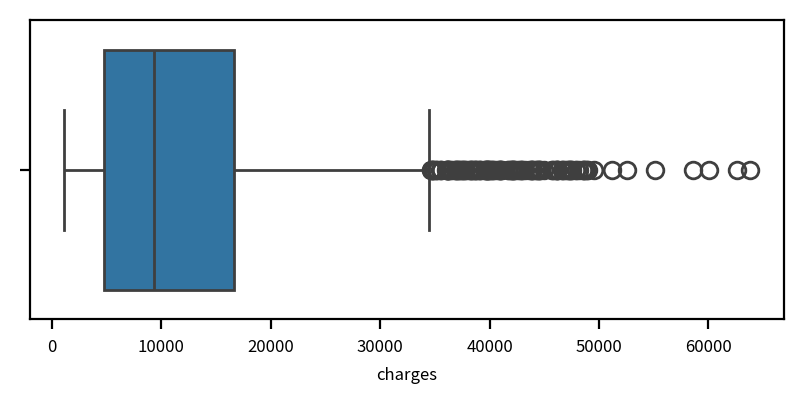

In [9]:
width_px=800
height_px=400
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=origin, x='charges')

plt.tight_layout()
plt.show()
plt.close()

In [10]:
origin[origin['charges']==origin['charges'].max()]

,age,sex,bmi,children,smoker,region,charges
543,54,female,47.41,0,yes,southeast,63770.42801


☝️ 돈 많이 낼법함....

In [11]:
# 현재 원화 환율 1479.60

print('원화로 변환한 의료보험 청구 비용 : %d원'%(origin['charges'].max()*1479.6))

원화로 변환한 의료보험 청구 비용 : 94354725원


☝️ 그런데 9435만원 미친건가요?

원화로 바꿔보니까 말이 안됨.....

IQR보다 큰 값들은 삭제해보기

In [12]:
charges_Q1=origin['charges'].quantile(0.25)
charges_Q3=origin['charges'].quantile(0.75)
charges_IQR=charges_Q3-charges_Q1
# origin[origin['charges']>charges_IQR]=charges_IQR
# origin['charges'].max()

df=origin.drop(index=origin[origin['charges']>charges_IQR].index)
df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
4,32,male,28.88,0,no,northwest,3866.8552
5,31,female,25.74,0,no,southeast,3756.6216
6,46,female,33.44,1,no,southeast,8240.5896


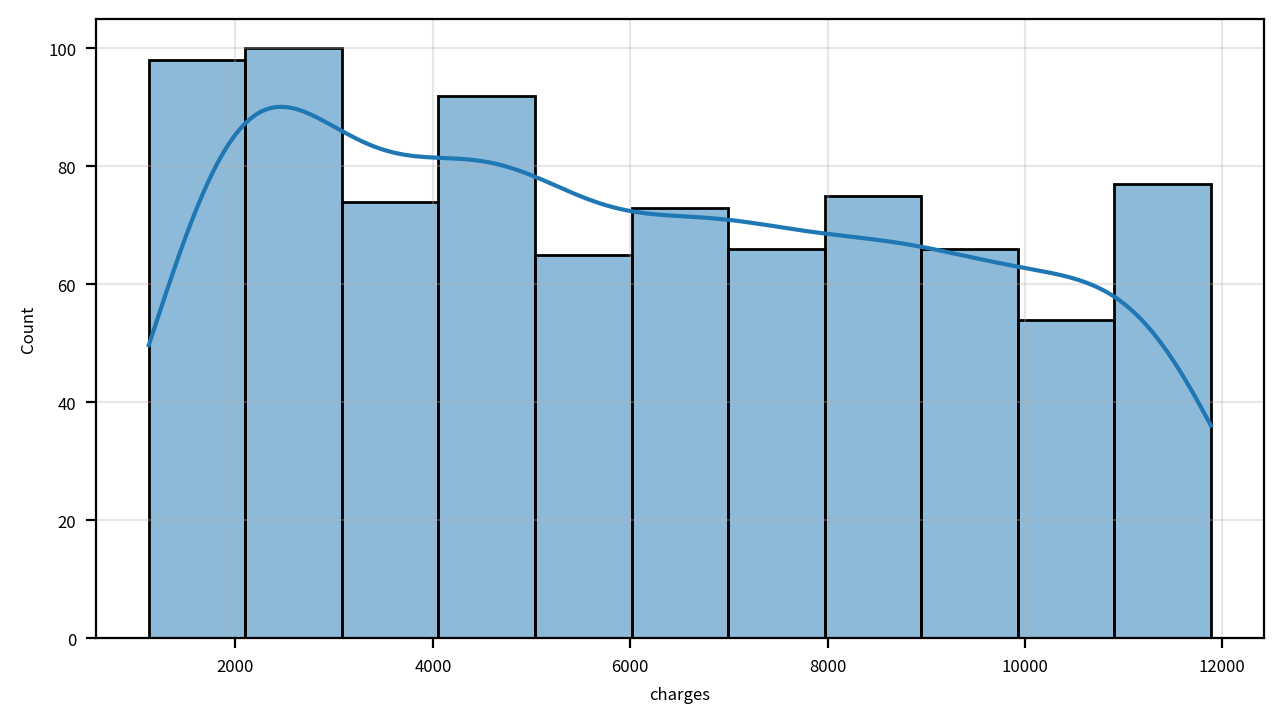

In [13]:
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.histplot(data=df, x='charges', kde=True)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

### 1-3) 범주형 변수들 확인

In [14]:
print('sex 변수의 범주 종류 :',df['sex'].unique())
print('smoker 변수의 범주 종류 :',df['smoker'].unique())
print('region 변수의 범주 종류 :',df['region'].unique())

sex 변수의 범주 종류 : ['male' 'female']
smoker 변수의 범주 종류 : ['no']
region 변수의 범주 종류 : ['southeast' 'northwest' 'northeast' 'southwest']


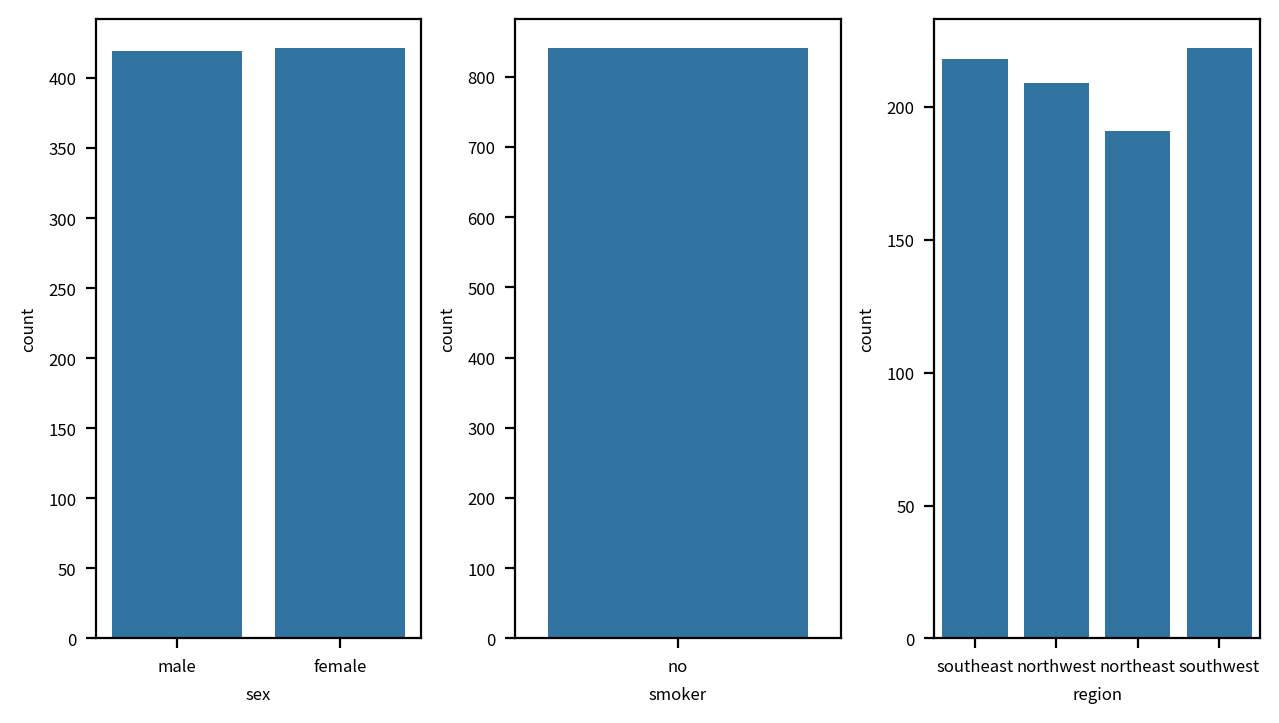

In [15]:
width_px=1280
height_px=720
rows=1
cols=3
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.countplot(data=df, x='sex', ax=ax[0])
sb.countplot(data=df, x='smoker', ax=ax[1])
sb.countplot(data=df, x='region', ax=ax[2])

plt.tight_layout()
plt.show()
plt.close()

charges가 비정상적으로 크다고 생각했던 값들을 제거했더니..... 흡연자가 모두 사라지는 기염을 토함.  
원래 데이터로 진행하기로 결정........ (어이X)

In [16]:
# df=origin.copy()

# df['bmi_cat']=''
# for i in range(0, len(df['bmi_cat'])):
#     df.loc[i,'bmi_cat']=('Underweight (Severe thinness)' if df.loc[i,'bmi']<=16 
#                 else 'Underweight (Moderate thinness)' if df.loc[i,'bmi']<=17 
#                 else 'Underweight (Mild thinness)' if df.loc[i,'bmi']<=18.5 
#                 else 'Normal range' if df.loc[i,'bmi']<=25 
#                 else 'Overweight (Pre-obese)' if df.loc[i,'bmi']<=30
#                 else 'Obese (Class I)' if df.loc[i,'bmi']<=35
#                 else 'Obese (Class I)' if df.loc[i,'bmi']<=40
#                 else 'Obese (Class III)')
# df['bmi_cat'].head()

## 🎯미션2. 의료비와 핵심 변수 살펴보기

### 2-1) charges, age, bmi, chidren 분포를 히스토그램/KDE로 확인하기

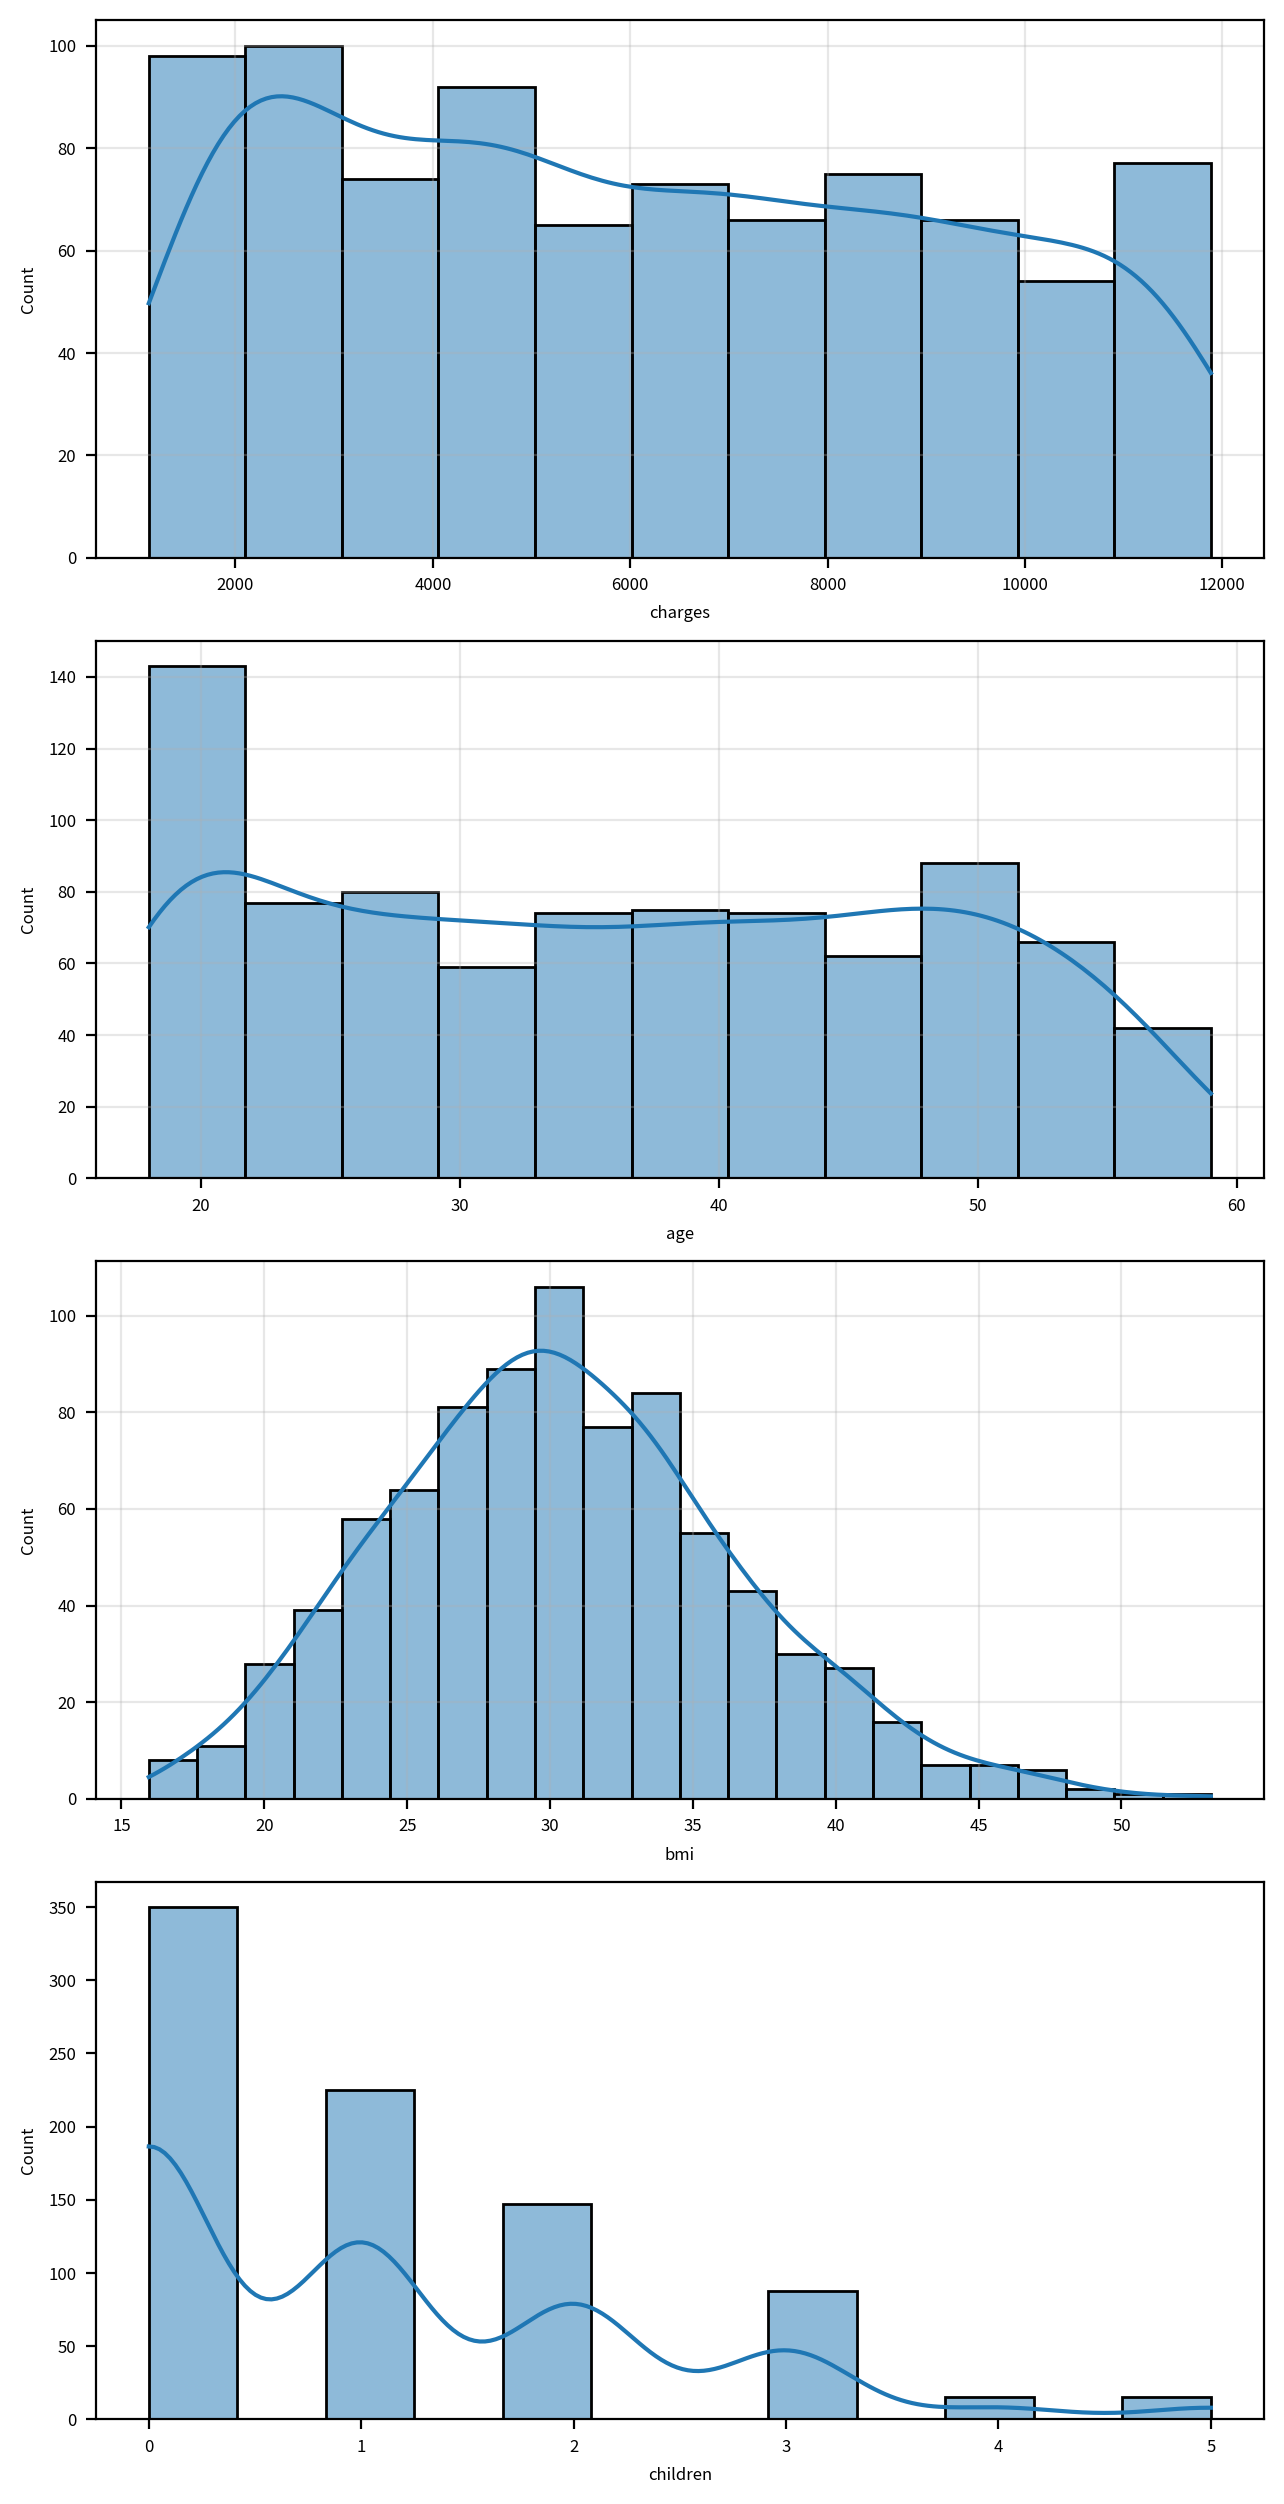

In [17]:
width_px=1280
height_px=2500
rows=4
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.histplot(data=df, x='charges', ax=ax[0], kde=True)
sb.histplot(data=df, x='age', ax=ax[1], kde=True)
sb.histplot(data=df, x='bmi', ax=ax[2], kde=True)
sb.histplot(data=df, x='children', ax=ax[3], kde=True)
# sb.histplot(data=df, x='bmi_cat', ax=ax[4], kde=True)

ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

## 🎯미션3. 로그/비선형 변환 고려

In [18]:
# 로그 변환
df['charges_log']=np.log(df['charges'])
df['age_log']=np.log(df['age'])
df['bmi_log']=np.log(df['bmi'])
# df['children_log']=np.log(df['children'])             # 변수값이 0이 포함된 컬럼은 로그변환을 취하면 오류 발생

# 제곱근 변환
df['charges_sqrt']=np.sqrt(df['charges'])
df['age_sqrt']=np.sqrt(df['age'])
df['bmi_sqrt']=np.sqrt(df['bmi'])
df['children_sqrt']=np.sqrt(df['children'])

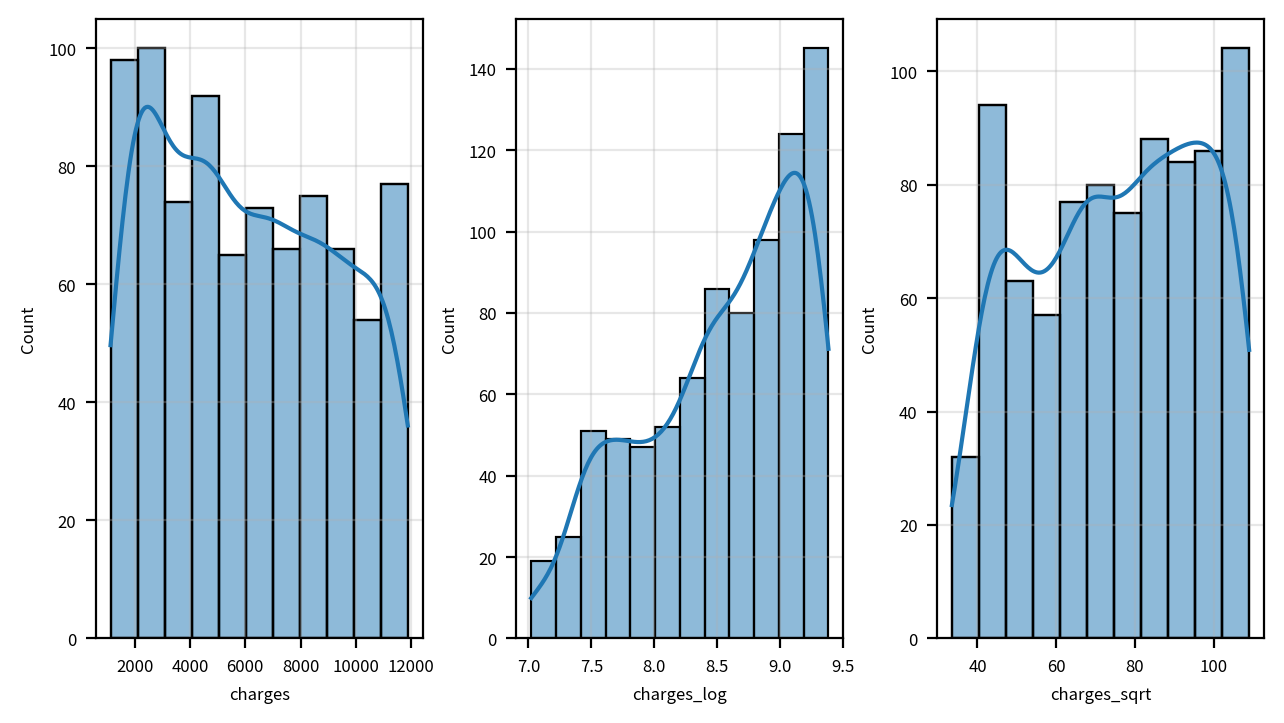

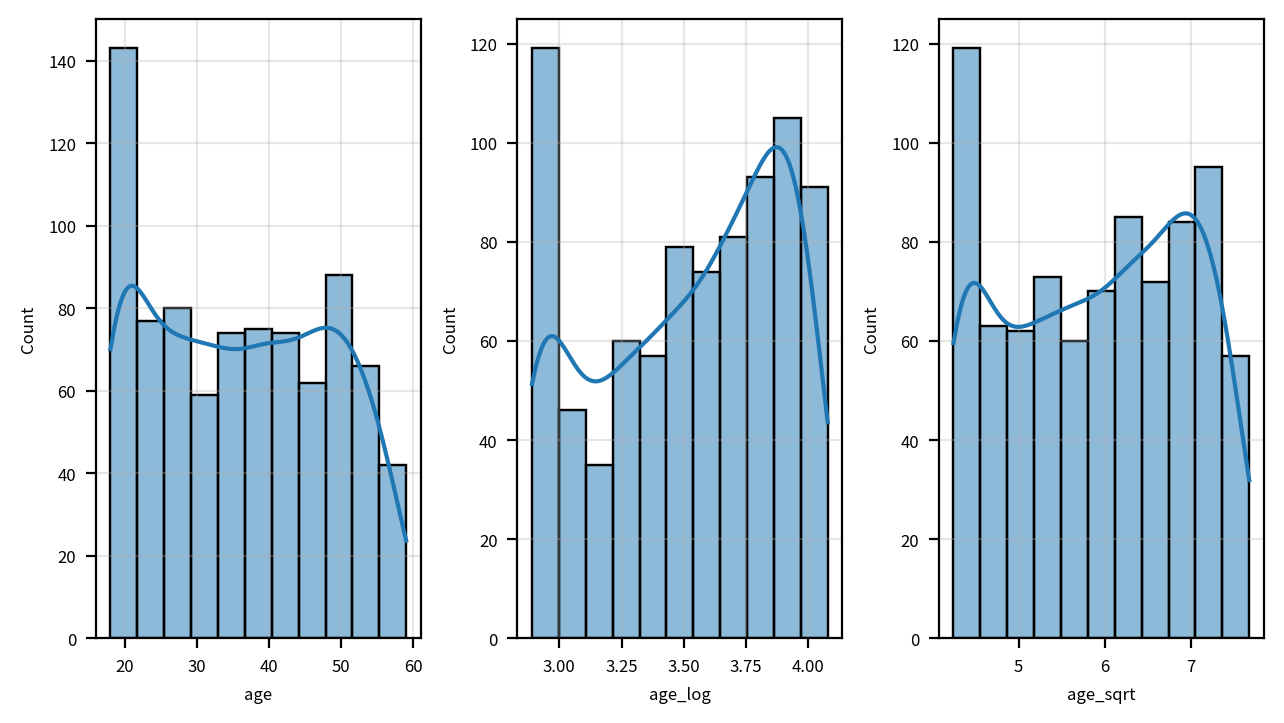

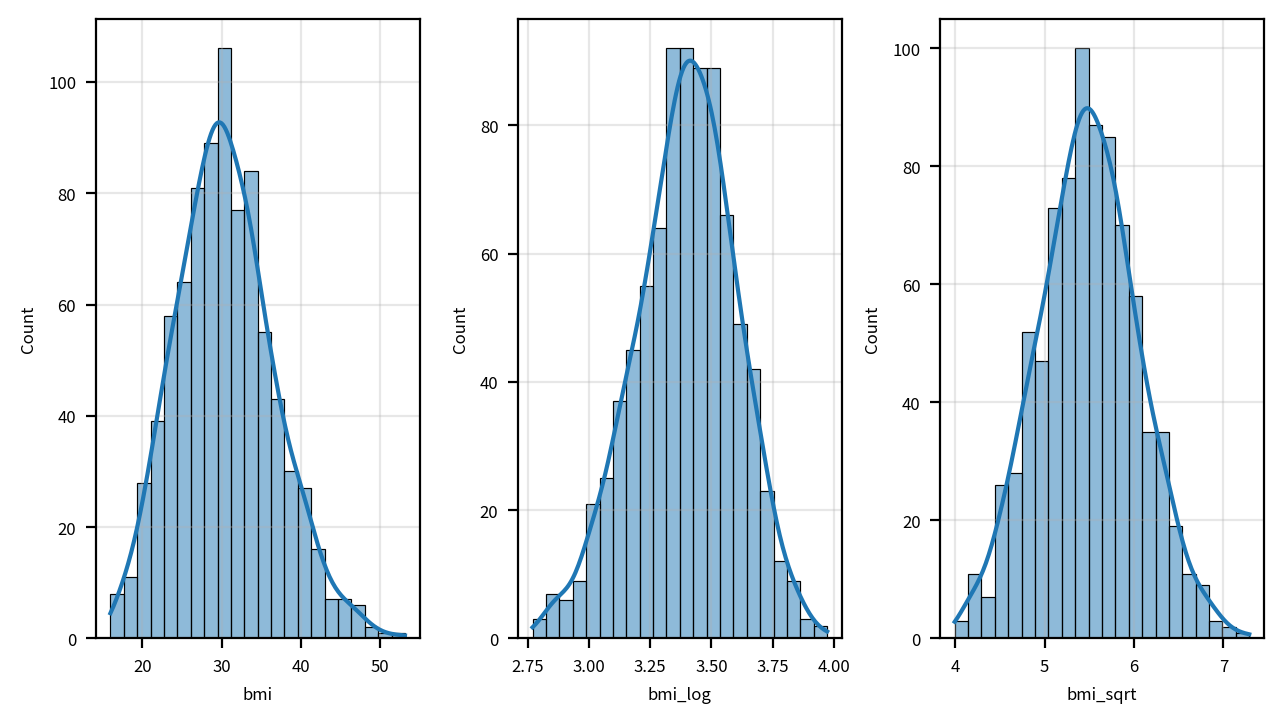

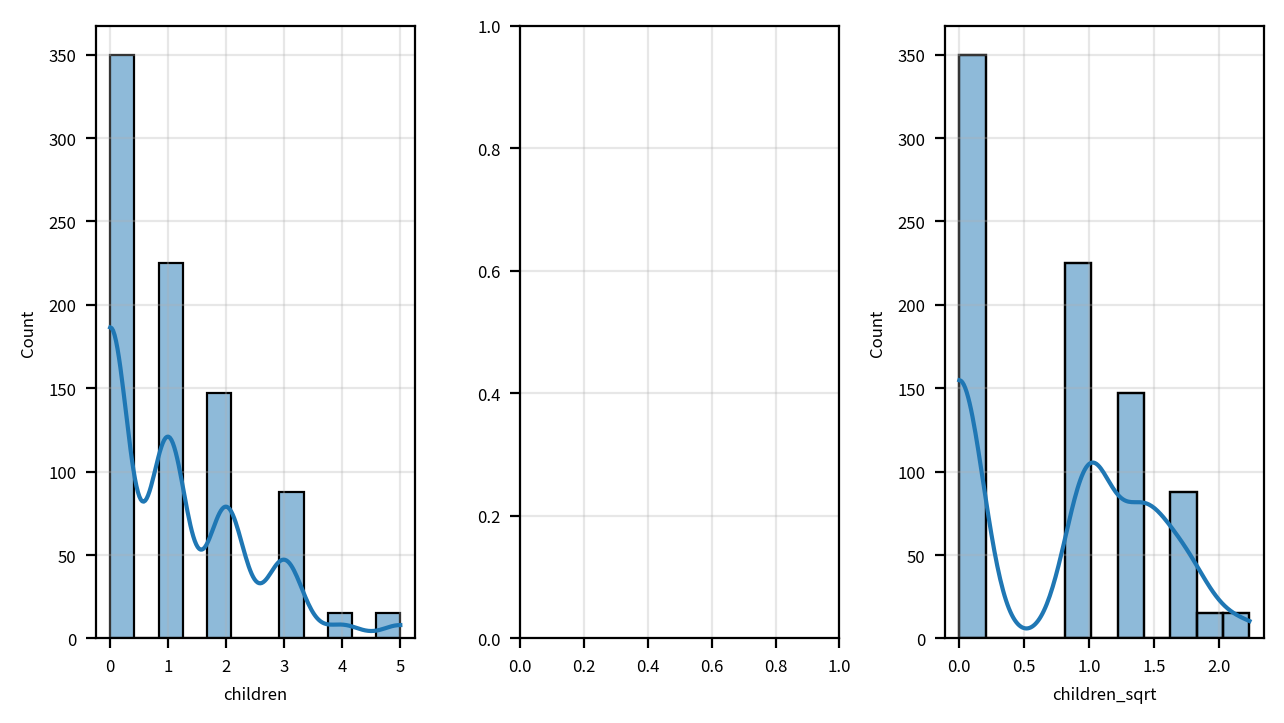

In [26]:
mylist=['charges', 'age', 'bmi']

for v in mylist:
    width_px=1280
    height_px=720
    rows=1
    cols=3
    figsize=(width_px/my_dpi, height_px/my_dpi)
    fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

    sb.histplot(data=df, x=v, ax=ax[0], kde=True)
    sb.histplot(data=df, x=f'{v}_log', ax=ax[1], kde=True)
    sb.histplot(data=df, x=f'{v}_sqrt', ax=ax[2], kde=True)

    ax[0].grid(True, alpha=0.3)
    ax[1].grid(True, alpha=0.3)
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

width_px=1280
height_px=720
rows=1
cols=3
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.histplot(data=df, x='children', ax=ax[0], kde=True)
sb.histplot(data=df, x='children_sqrt', ax=ax[2], kde=True)

ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()